In [3]:
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
import numpy as np
from scipy import stats
import shap

<h1 style="text-align:center">Response Prediction Using XGBoost Classifier</h1>

Source Codes:
- [XGBoost Hyperparameter Tuning (Optuna)](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)
- [XGBoost Binary Classification Pipeline](https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn#Binary-classification)

In [8]:
data = pd.read_csv("../../data/phq9_data.csv")
target = data.phq9_response
neg, pos = target.value_counts()

In [9]:
SEED = 42
N_FOLDS = 10
SPW = neg / pos

In [18]:
def objective(trial):
    data = pd.read_csv("../../data/phq9_data.csv")
    y = data.pop("phq9_response")
    X = data

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "use_label_encoder": False,
        "eval_metric": "auc",
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        param["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    mcc_scores = []
    best_n_estimators_list = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        clf = xgb.XGBClassifier(
            **param,
            n_estimators=10000,
            early_stopping_rounds=200,
            seed=SEED,
            scale_pos_weight=SPW,
        )

        clf.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        preds = clf.predict(X_valid)
        mcc = matthews_corrcoef(y_valid, preds)
        mcc_scores.append(mcc)
        best_n_estimators_list.append(clf.best_iteration)

    trial.set_user_attr("n_estimators", int(np.mean(best_n_estimators_list)))
    return np.mean(mcc_scores)


if __name__ == "__main__":
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500, timeout=1800)
    best_trial = study.best_trial

    print(f"Max MCC Value: {best_trial.value}")

    best_params = study.best_params
    n_estimators = best_trial.user_attrs["n_estimators"]

[I 2025-09-16 18:42:00,594] A new study created in memory with name: no-name-7b72671a-2eca-473d-8576-a6963e9112a0
[I 2025-09-16 18:42:10,098] Trial 0 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 4.3680876880514294e-05, 'alpha': 8.094491445985468e-06, 'subsample': 0.4367965690234729, 'colsample_bytree': 0.5587015196956397, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.0008351363974052494, 'gamma': 0.034787873068190416, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.9560786906062986e-07, 'skip_drop': 3.633861775936928e-05}. Best is trial 0 with value: 0.0.
[I 2025-09-16 18:42:11,259] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.002034425150805574, 'alpha': 0.0003311211691945461, 'subsample': 0.2102209816049129, 'colsample_bytree': 0.5333853260657606, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.0012281240914340746, 'gamma': 0.0319581639032741, 'grow_policy': 'lossguide'

Max MCC Value: 0.4881812809226286


In [19]:
def metric_ci(scores):
    mean = np.mean(scores)
    sem = stats.sem(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean, scale=sem)
    return f"Mean: {mean:.3f} (95% CI: {ci[0]:.3f}-{ci[1]:.3f})"

def eval_best_model():
    data = pd.read_csv("../../data/phq9_data.csv")
    y = data.pop("phq9_response")
    X = data
    
    n_folds = 10
    spw = 1.56
    seed = 42

    best_trial = study.best_trial
    n_estimator = best_trial.user_attrs["n_estimators"]

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    mccs, accs, f1s = [], [], []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = xgb.XGBClassifier(
            **best_params,
            verbosity=0,
            use_label_encoder=False,
            objective="binary:logistic",
            random_state=seed,
            scale_pos_weight=spw,
            eval_metric="auc",
            n_estimators=n_estimators,
            early_stopping_rounds=100,
        )

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        preds = model.predict(X_valid)

        mccs.append(matthews_corrcoef(y_valid, preds))
        accs.append(accuracy_score(y_valid, preds))
        f1s.append(f1_score(y_valid, preds))

    print(f"Optuna MCC {best_trial.value}\n")
    print(f"MCC {metric_ci(mccs)}")
    print(f"Accuracy {metric_ci(accs)}")
    print(f"F1 Score {metric_ci(f1s)}")

In [20]:
eval_best_model()

Optuna MCC 0.4881812809226286

MCC Mean: 0.375 (95% CI: 0.034-0.716)
Accuracy Mean: 0.714 (95% CI: 0.583-0.845)
F1 Score Mean: 0.771 (95% CI: 0.670-0.872)


In [21]:
best_trial.params

{'booster': 'dart',
 'lambda': 8.314355307826247e-07,
 'alpha': 6.153836248100456e-06,
 'subsample': 0.8325097837664188,
 'colsample_bytree': 0.8915361285617307,
 'max_depth': 5,
 'min_child_weight': 2,
 'eta': 0.9901119699157506,
 'gamma': 1.7293804925657856e-07,
 'grow_policy': 'depthwise',
 'sample_type': 'weighted',
 'normalize_type': 'forest',
 'rate_drop': 0.0008531784787804751,
 'skip_drop': 2.7923683053187886e-08}

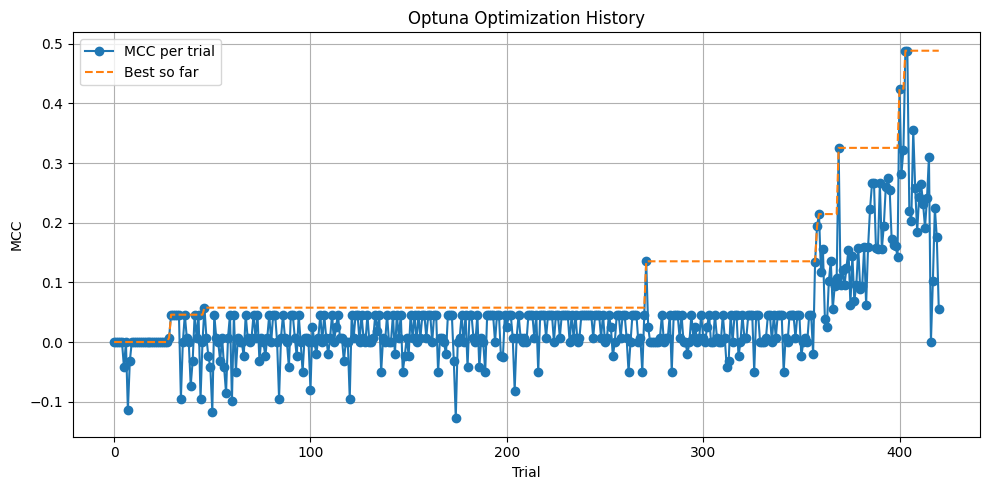

In [22]:
import matplotlib.pyplot as plt

values = [t.value for t in study.trials]

plt.figure(figsize=(10, 5))
plt.plot(values, marker="o", label="MCC per trial")
plt.plot(np.maximum.accumulate(values), label="Best so far", linestyle="--")
plt.title("Optuna Optimization History")
plt.xlabel("Trial")
plt.ylabel("MCC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP

In [23]:

def model_shap():
    data = pd.read_csv("../../data/phq9_data.csv")
    y = data.pop("phq9_response")
    X = data
    n_folds = 10
    spw = 1.56
    seed = 42

    final_model = xgb.XGBClassifier(
                **best_params,
                verbosity=0,
                use_label_encoder=False,
                objective="binary:logistic",
                random_state=seed,
                scale_pos_weight=spw,
                eval_metric="auc",
                n_estimators=n_estimators
            )

    final_model.fit(X,y)
    explainer = shap.TreeExplainer(final_model, shap.maskers.Independent(X))
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type="violin", max_display=X.shape[1])

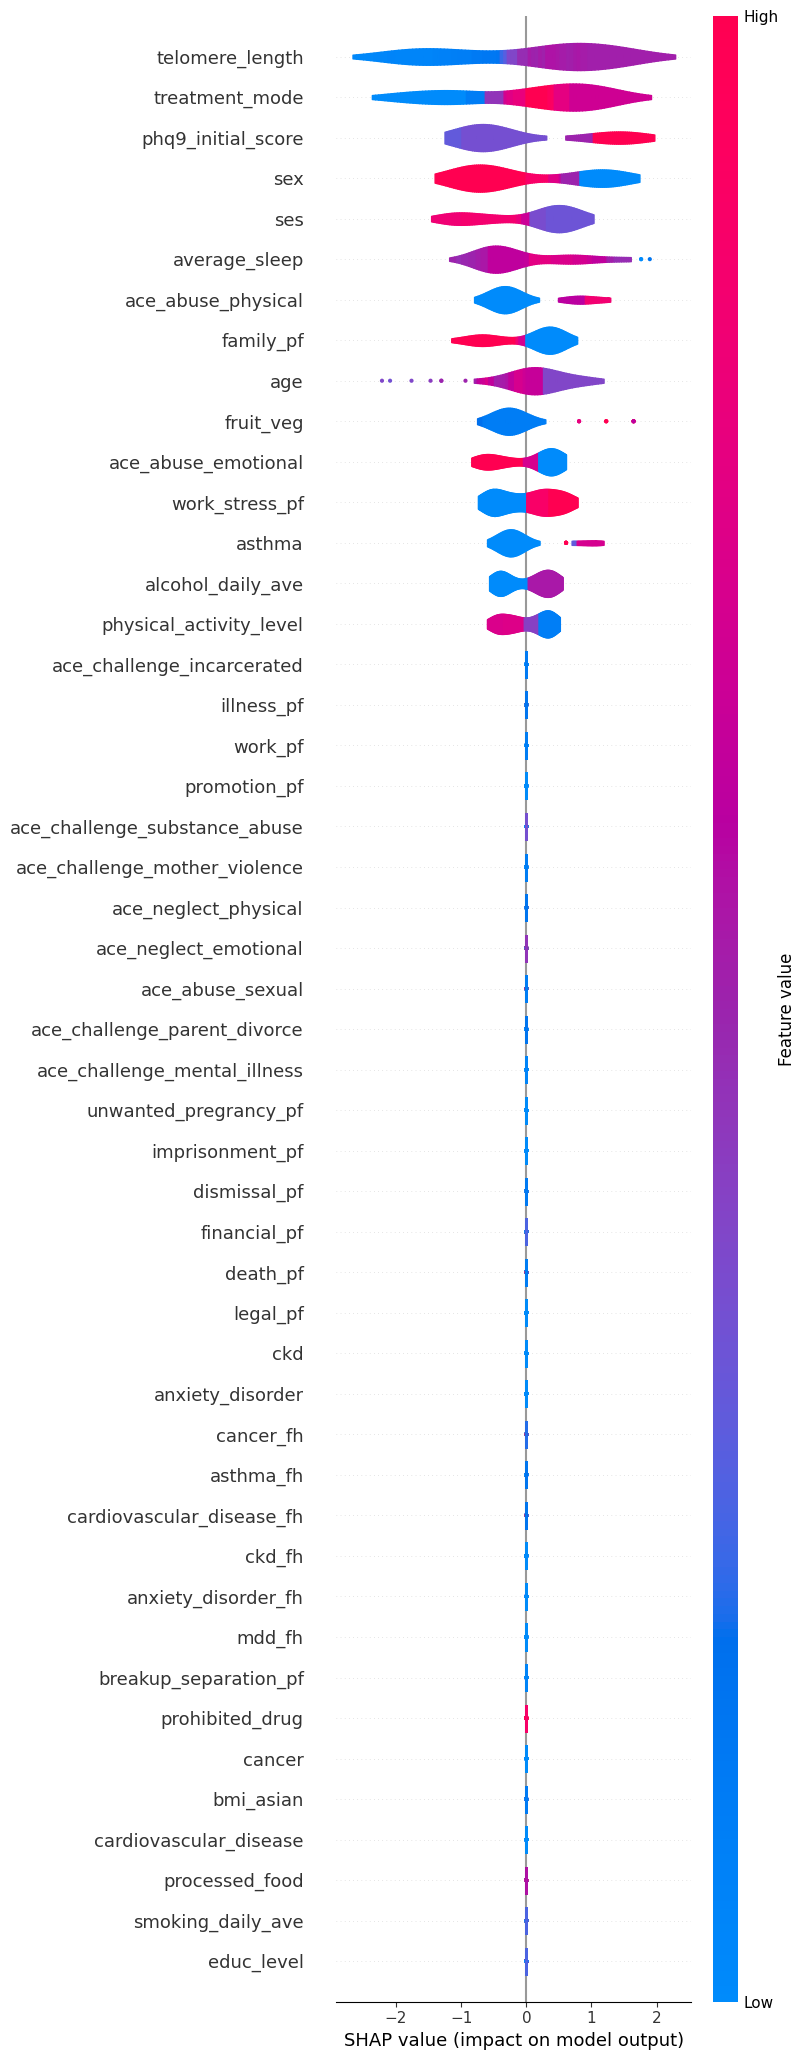

In [24]:
model_shap()